In [7]:
import nltk 
# nltk.download('stopwords')               #use only first time 
import re                                  # library for regular expression operations\
import string                              # for string operations\
from nltk.corpus import stopwords          # module for stop words that come with NLTK\
from nltk.stem import PorterStemmer        # module for stemming\
from nltk.tokenize import TweetTokenizer
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt 
from tensorflow.keras.optimizers import Adam
import pickle

In [2]:
df = pd.read_csv('Twitter_Data.csv', index_col=False)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [4]:
df1 = df.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


In [5]:
df =  df1.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


## PreProcess the Text
       Remove hyperlinks
       Remove hashtags
       Tokenizer class
       Stop word and punctuation

In [6]:
x= df['clean_text']
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
stopwords_english = stopwords.words('english')
ps = PorterStemmer()
cleanList=[]
for i in x:
    # Remove  hyperLink
    i = re.sub(r'https?://[^\\s\\n\\r]+', '', str(i))
    # Remove Hastag
    i = re.sub(r'#', '', i)
    # Lowercase
    i = i.lower()
    # Tokenizer
    tweet_tokens = tokenizer.tokenize(i)
    # stopword and puncuation
    tweets_clean=[]
    for word in tweet_tokens: # Go through every word in your tokens list\
        if (word not in stopwords_english and  word not in string.punctuation):
                tweets_clean.append(ps.stem(word))
    cleanList.append(tweets_clean)
print(cleanList[:5])    

[['modi', 'promis', '“', 'minimum', 'govern', 'maximum', 'govern', '”', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ'], ['talk', 'nonsens', 'continu', 'drama', 'vote', 'modi'], ['say', 'vote', 'modi', 'welcom', 'bjp', 'told', 'rahul', 'main', 'campaign', 'modi', 'think', 'modi', 'relax'], ['ask', 'support', 'prefix', 'chowkidar', 'name', 'modi', 'great', 'servic', 'confus', 'read', 'crustal', 'clear', 'crass', 'filthi', 'nonsens', 'see', 'abus', 'come', 'chowkidar'], ['answer', 'among', 'power', 'world', 'leader', 'today', 'trump', 'putin', 'modi', 'may']]


In [9]:
with open('CleanList', 'wb') as fp:
        pickle.dump(cleanList, fp)
        print('Done writing list into a binary file')
## Read the file back
# with open('sampleList', 'rb') as fp:
#         n_list = pickle.load(fp)

Done writing list into a binary file


## Create Frequency Distro

In [11]:
f= dict()
for i,y in zip(cleanList,df['category']):
    for k in i:
        if((k,y) not in f.keys()):
            f[(k,y)] = 1
        else:
            f[(k,y)] += 1
# print(f.keys())            

In [12]:
with open('FrequencyDistro', 'wb') as fp:
        pickle.dump(f, fp)
        print('Done writing list into a binary file')

Done writing list into a binary file


## Create the new dataset using the frequency distro 

In [13]:
X = np.array(())
for i in cleanList:
    p,ne,n=0,0,0
    for j in i:
        if((j,1.0) in f.keys()):
            p = p + f[(j,1.0)]
        if((j,0.0) in f.keys()):
            ne = ne + f[( j, 0.0)]
        if((j,-1.0) in f.keys()):
            n = n + f[( j, -1.0)]
    X = np.append(X,[p, ne , n , 1.0])
X = np.reshape(X,(df.shape[0],4))
print(X[5][:])

[752. 516. 487.   1.]


In [14]:
from sklearn.preprocessing import StandardScaler
X=StandardScaler().fit_transform(X)
X

array([[ 0.20225293,  0.16533305,  0.3025269 ,  0.        ],
       [-0.27438863, -0.15552684, -0.25539405,  0.        ],
       [ 3.35484359,  3.58507247,  3.39739672,  0.        ],
       ...,
       [-2.04628297, -2.00438633, -2.04292436,  0.        ],
       [ 0.02821576, -0.00483215, -0.02742069,  0.        ],
       [ 0.29723364,  0.21693153,  0.28889234,  0.        ]])

In [15]:
np.savetxt("X.csv", X, delimiter=",")

## Spliting data for training set

In [16]:
xtrain = X[:int(X.shape[0]*0.8)]
y = np.array(df['category'])

In [17]:
yN =[]
for i in y:
    if(i == 1.0):
        yN.append([1,0,0])
    elif(i==0.0):
        yN.append([0,1,0])
    else:
        yN.append([0,0,1])
yN[:5]        

[[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]

In [18]:
ytrain = np.array(yN[:int(X.shape[0]*0.8)])
xtest = X[int(X.shape[0]*0.8):]
ytest = np.array(yN[int(X.shape[0]*0.8):])
ytrain = np.reshape(ytrain,(ytrain.shape[0],3))
ytest = np.reshape(ytest,(ytest.shape[0],3))
print(ytrain.shape, ytest.shape)

(130375, 3) (32594, 3)


In [19]:
ytrain[:,0].shape

(130375,)

## Building muticlass logistic reg using TensorFlow

In [20]:
x = tf.constant(xtrain, dtype=tf.float32)
y_1 = tf.constant(ytrain[:,0], shape=[1,ytrain.shape[0]],dtype=tf.float32)
y_0 = tf.constant(ytrain[:,1], shape=[1,ytrain.shape[0]],dtype=tf.float32)
y_neg = tf.constant(ytrain[:,2], shape=[1,ytrain.shape[0]],dtype=tf.float32)
y_1.shape

TensorShape([1, 130375])

## Initial Weights For Sigmoid function

In [22]:
w_1=tf.Variable(tf.random.uniform(shape=[1,4], minval=1,maxval=3, dtype=tf.float32, seed=123456789))
w_0=tf.Variable(tf.random.uniform(shape=[1,4], minval=1,maxval=3, dtype=tf.float32, seed=123456789))
w_neg=tf.Variable(tf.random.uniform(shape=[1,4], minval=1,maxval=3, dtype=tf.float32, seed=123456789))
w_neg

<tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[2.1119685, 1.23968  , 1.6243591, 2.7723637]], dtype=float32)>

## Sigmoid ML model

In [23]:
opti= Adam(learning_rate=1e-1)
min_val,max_val = 1e-7,1e+7
iter =3000
c=[]
for i in range(iter):
    with tf.GradientTape() as tape:
        yhat_1 = tf.sigmoid(tf.matmul(w_1,tf.transpose(x)))
        # yhat_1= tf.clip_by_value(yhat_1, clip_value_min=1e-5, clip_value_max=1)
        yhat_0 = tf.math.sigmoid(tf.matmul(w_0,tf.transpose(x)))
        # yhat_0= tf.clip_by_value(yhat_0, clip_value_min=1e-5, clip_value_max=1)
        yhat_neg = tf.math.sigmoid(tf.matmul(w_neg,tf.transpose(x)))
        # yhat_neg= tf.clip_by_value(yhat_neg, clip_value_min=1e-5, clip_value_max=1)
        
        cost_1 = sum((tf.matmul(y_1,tf.transpose(tf.math.log((tf.clip_by_value(yhat_1, clip_value_min=min_val, clip_value_max=max_val)))))+tf.matmul(tf.subtract(1,y_1),tf.transpose(tf.math.log(tf.clip_by_value(tf.subtract(1,yhat_1), clip_value_min=min_val, clip_value_max=max_val))))))
        cost_0 = sum(tf.matmul(y_0,tf.transpose(tf.math.log(tf.clip_by_value(yhat_0, clip_value_min=min_val, clip_value_max=max_val))))+tf.matmul(tf.subtract(1,y_0),tf.transpose(tf.math.log(tf.clip_by_value(tf.subtract(1,yhat_0), clip_value_min=min_val, clip_value_max=max_val)))))
        cost_neg = sum(tf.matmul(y_neg,tf.transpose(tf.math.log(tf.clip_by_value(yhat_neg, clip_value_min=min_val, clip_value_max=max_val))))+tf.matmul(tf.subtract(1,y_neg),tf.transpose(tf.math.log(tf.clip_by_value(tf.subtract(1,yhat_neg), clip_value_min=min_val, clip_value_max=max_val)))))
        
        s =-(cost_1+cost_0+cost_neg)/x.shape[0]

    c.append(s)
    grad = tape.gradient(s,[w_1,w_0,w_neg])
    opti.apply_gradients(zip(grad,[w_1,w_0,w_neg])) # adma optimizer
    

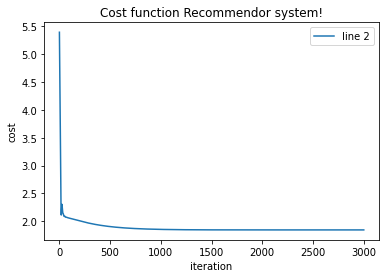

In [24]:
l=np.arange(1,len(c)+1)
plt.plot(l, c, label = "line 2")
  
# naming the x axis -->
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('cost')
# giving a title to my graph
plt.title('Cost function Recommendor system!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

##  Sigmoid Prediction

In [25]:
extra_1 = np.exp(-np.matmul(w_1,np.transpose(xtest)))
extra_0 = np.exp(-np.matmul(w_0,np.transpose(xtest)))
extra_neg = np.exp(-np.matmul(w_neg,np.transpose(xtest)))

# extra.shape
temp_1 = 1/(1+extra_1)
temp_0 = 1/(1+extra_0)
temp_neg = 1/(1+extra_neg)
print(temp_1.shape)
yhat = []
o,z,no=0,0,0
a= temp_1.reshape((temp_1.shape[1],)).tolist()
b= temp_0.reshape((temp_0.shape[1],)).tolist()
c= temp_neg.reshape((temp_neg.shape[1],)).tolist()
# print(a)
for i,j,k in zip(a,b,c):
        big = max(i,j,k)
        if(i == big):
            yhat.append(1.0)
            o=o+1
        elif(j == big):
            yhat.append(0.0)
            z=z+1
        elif(k == big):
            yhat.append(-1.0)
            no=no+1
        
print(o,z,no)  

(1, 32594)
8996 14744 8854


In [26]:
np.savetxt("w_1.csv", w_1, delimiter=",")
np.savetxt("w_0.csv", w_0, delimiter=",")
np.savetxt("w_neg.csv", w_neg, delimiter=",")


## Acurracy

In [27]:
ytN=np.array(y[int(X.shape[0]*0.8):])
ytest = np.array(ytN)
ytest = np.reshape((ytest),(ytest.shape[0],1))
ytest.shape

(32594, 1)

In [28]:
yhat = np.array(yhat)
yhat=np.reshape((yhat),(yhat.shape[0],1))
yhat.shape

(32594, 1)

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, yhat)

0.5563600662698657

In [30]:
from sklearn.metrics import f1_score
f1_score(ytest, yhat, average='micro')

0.5563600662698657

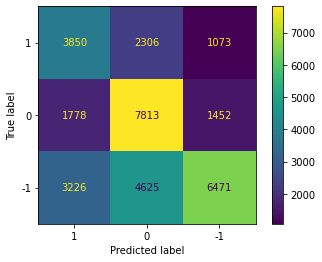

In [31]:
from sklearn.metrics import *

confusion_matrix = confusion_matrix(ytest, yhat)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 0,-1])

cm_display.plot()
plt.show()

## Inital Weights for Softmax

In [32]:
w=tf.Variable(tf.random.uniform(shape=[3,4], minval=0,maxval=15, dtype=tf.float32, seed=123456789))
w

<tf.Variable 'Variable:0' shape=(3, 4) dtype=float32, numpy=
array([[11.660618 ,  5.484522 ,  4.03683  , 14.919266 ],
       [ 8.750995 ,  8.483046 ,  3.940875 ,  3.9068913],
       [ 8.915377 , 10.477329 ,  9.566934 ,  1.2442714]], dtype=float32)>

## SoftMax ML Model

In [33]:
opti= Adam(learning_rate=1e-1)
iter =3000
c=[]
ytrain=tf.constant(ytrain,dtype=tf.float32)
loss=tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
for i in range(iter):
    with tf.GradientTape() as tape:
        yhat = tf.nn.softmax(tf.matmul(x,tf.transpose(w)),axis=1)
        cost = loss(yhat, ytrain)
        
    c.append(cost)
    grad = tape.gradient(cost,[w])
    opti.apply_gradients(zip(grad,[w])) # adma optimizer

In [45]:
np.savetxt("SoftmaxWeights.csv", w, delimiter=",")

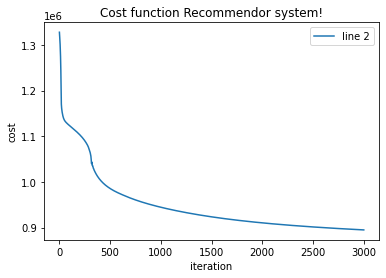

In [34]:
l=np.arange(1,len(c)+1)
plt.plot(l, c, label = "line 2")
  
# naming the x axis -->
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('cost')
# giving a title to my graph
plt.title('Cost function Recommendor system!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

## Softmax prediction

In [35]:
xtest = tf.constant(xtest, dtype=tf.float32)
yhatN = tf.nn.softmax(tf.matmul(xtest,tf.transpose(w)),axis=1).numpy()
yhat = []
for i in yhatN:
    a = np.argmax(i)
    if(a==0):
        yhat.append(1.0)
    elif(a==1):
        yhat.append(0.0)
    else:
        yhat.append(-1.0)
        

In [36]:
## Accuracy
yhat = np.array(yhat)
yhat=np.reshape((yhat),(yhat.shape[0],1))
print(accuracy_score(ytest, yhat))
print(f1_score(ytest, yhat, average='micro'))


0.5744308768484997
0.5744308768484997


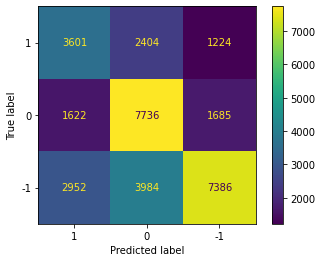

In [37]:
from sklearn.metrics import *

confusion_matrix = confusion_matrix(ytest, yhat)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 0,-1])

cm_display.plot()
plt.show()

## Traning the model on built in Logistic reg for multinomial class

In [38]:
from sklearn import linear_model

In [39]:
model_LOR = linear_model.LogisticRegression(multi_class='ovr',solver='liblinear',max_iter=3000, verbose=2)

In [40]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.2, random_state = 1)
y_test.shape

(32594,)

In [41]:
model_LOR.fit(X_train, y_train)

[LibLinear]

LogisticRegression(max_iter=3000, multi_class='ovr', solver='liblinear',
                   verbose=2)

In [42]:
y_hat = model_LOR.predict(X_test)
y_hat.shape

(32594,)

In [43]:
accuracy_score(y_test, y_hat)

0.6096520832054979

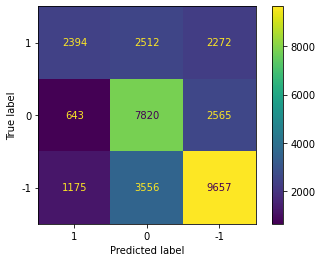

In [44]:
from sklearn.metrics import *
confusion_matrix = confusion_matrix(y_test, y_hat)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 0,-1])

cm_display.plot()
plt.show()